In [10]:
import scipy
import networkx as nx
import pybind11
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import shapely 
import os
import sys
from shapely import wkt
from shapely.geometry import Point
import random
from geopy.distance import geodesic
import re

In [11]:
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/writing/RealEstateBrokerage/network_estimation')
import network_formulation
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/oritignal cleaning/RealEstateBrokerage')

In [12]:
data = pd.read_stata('template.dta')
codebook = {
    1: '北京市',
    2: '成都市',
    3: '重庆市',
    4: '广州市',
    5: '杭州市',
    6: '南京市',
    7: '上海市',
    8: '深圳市',
    9: '天津市',
    10: '武汉市'
}

data['city_id'] = data['city_id'].map(codebook)
print(len(data))

217200


In [13]:
map_data = data[(data['city_id'] == '北京市') & (data['year'] == 2021)]
print(len(map_data))

0


In [14]:
def construct_graph(df_network, df_edges):
    # now we need to convert the problem using cpp
    G = nx.Graph()

    store_ids = set(df_network['store_id']).union(df_edges['store_id_1']).union(df_edges['store_id_2'])
    for store_id in store_ids:
        G.add_node(f'Store {store_id}', color='red', shape='o')

    # Add nodes for communities
    community_ids = set(df_network['community_id'])
    for community_id in community_ids:
        G.add_node(f'Community {community_id}', color='blue', shape='s')

    # Add edges based on df_network
    for _, row in df_network.iterrows():
        store_id = row['store_id']
        community_id = row['community_id']
        effect = row['effect']
        G.add_edge(f'Store {store_id}', f'Community {community_id}', weight=1, color='gray', style='dotted')
        # we can also assign weight 1 for this result
    # Add edges based on df_edges
    for _, row in df_edges.iterrows():
        store_id_1 = row['store_id_1']
        store_id_2 = row['store_id_2']
        effect = row['effect']
        G.add_edge(f'Store {store_id_1}', f'Store {store_id_2}', weight=effect, color='black', style='solid')

    return G

In [15]:
def calculate_summary_statistics(centrality_dict):
    values = list(centrality_dict.values())
    return {
        'max': max(values),
        'mean': np.mean(values),
        'median': np.median(values)
    }

## NOTE

The following code may take a 60 minute to run and the key idea is to generate the effect dataframe, and we can directly load the dataframe without running the code

In [16]:
results = []

for i in range(0, len(data['city_id'].unique())):
    map_data = data[data['city_id'] == data['city_id'].unique()[i]]
    for j in range(0, len(map_data['year'].unique())):
        print('now working on {} in year {}'.format(data['city_id'].unique()[i], data['year'].unique()[j]))
        map_data = data[(data['city_id'] == data['city_id'].unique()[i]) & (data['year'] == data['year'].unique()[j])]
        map_data = gpd.GeoDataFrame(map_data, geometry = map_data.geometry.apply(wkt.loads))
        df = pd.read_csv("classifying brokerages/processed/{}_{}.csv".format(data['year'].unique()[j] - 2000, data['city_id'].unique()[i]))
        map_data['longitude'] = map_data['geometry'].apply(lambda point: point.x)
        map_data['latitude'] = map_data['geometry'].apply(lambda point: point.y)
        
        effects = map_data['number'].values
        stores = df[['gpsx', 'gpsy']].values.tolist()
        communities = map_data[['longitude', 'latitude']].values.tolist()
        
        within_distance_meters = 410.0 # this is what we find in the RD design
        # Perform network formation
        network, edges = network_formulation.network_formation(stores, communities, effects, within_distance_meters)
        
        df_edges = pd.DataFrame(edges, columns=["store_id_1", "store_id_2", "effect"])
        df_network = []
        for x, comm_effects in enumerate(network):
            for comm, effect in comm_effects:
                df_network.append((x, comm, effect))
        df_network = pd.DataFrame(df_network, columns=["store_id", "community_id", "effect"])
        
        G = construct_graph(df_network, df_edges)
        
        
        local_clustering = nx.clustering(G, weight='weight')
        average_clustering = nx.average_clustering(G, weight='weight')
        global_clustering = nx.transitivity(G)
        
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
        closeness_centrality = nx.closeness_centrality(G, distance='weight')
        
        # Calculate summary statistics for degree centrality
        degree_summary = calculate_summary_statistics(degree_centrality)
        # Calculate summary statistics for betweenness centrality
        betweenness_summary = calculate_summary_statistics(betweenness_centrality)
        # Calculate summary statistics for closeness centrality
        closeness_summary = calculate_summary_statistics(closeness_centrality)
        
        pagerank = nx.pagerank(G, weight='weight')
        pagerank_summary = calculate_summary_statistics(pagerank)
        
        connectivity = nx.node_connectivity(G)
        
        result = {
            'city_id': data['city_id'].unique()[i],
            'year': data['year'].unique()[j],
            'average_clustering': average_clustering,
            'global_clustering': global_clustering,
            'degree_centrality_max': degree_summary['max'],
            'degree_centrality_mean': degree_summary['mean'],
            'degree_centrality_median': degree_summary['median'],
            'betweenness_centrality_max': betweenness_summary['max'],
            'betweenness_centrality_mean': betweenness_summary['mean'],
            'betweenness_centrality_median': betweenness_summary['median'],
            'closeness_centrality_max': closeness_summary['max'],
            'closeness_centrality_mean': closeness_summary['mean'],
            'closeness_centrality_median': closeness_summary['median'],
            'pagerank_max': pagerank_summary['max'],
            'pagerank_mean': pagerank_summary['mean'],
            'pagerank_median': pagerank_summary['median'],
            'connectivity': connectivity
        }
        
        results.append(result)

now working on 北京市 in year 2016
now working on 北京市 in year 2017
now working on 北京市 in year 2018
now working on 北京市 in year 2019
now working on 北京市 in year 2020
now working on 成都市 in year 2016
now working on 成都市 in year 2017
now working on 成都市 in year 2018
now working on 成都市 in year 2019
now working on 成都市 in year 2020
now working on 成都市 in year 2021
now working on 重庆市 in year 2016
now working on 重庆市 in year 2017
now working on 重庆市 in year 2018
now working on 重庆市 in year 2019
now working on 重庆市 in year 2020
now working on 重庆市 in year 2021
now working on 重庆市 in year 2022
now working on 广州市 in year 2016
now working on 广州市 in year 2017
now working on 广州市 in year 2018
now working on 广州市 in year 2019
now working on 广州市 in year 2020
now working on 广州市 in year 2021
now working on 广州市 in year 2022
now working on 杭州市 in year 2016
now working on 杭州市 in year 2017
now working on 杭州市 in year 2018
now working on 杭州市 in year 2019
now working on 杭州市 in year 2020
now working on 杭州市 in year 2021
now work

The local clustering coefficient for a node $i$ is a measure of the likelihood that the neighbors of $i$ are also neighbors of each other, and it is calcualted as:

$$
C_i = \frac{2e_i}{k_i(k_i - 1)}
$$

where $e_i$ is the number of edges between the neighbors of node $i$ and $k_i$ is the degree of node $i$. The average clustering coefficient is the mean of the local clustering coefficients for all nodes in the network, defined as: $C = \frac{1}{n} \sum_{i=1}^n C_i$ where $n$ is the total number of nodes. This index indicates how close the neighbors of a node are to forming a complete graph (clique).

The global clustering coefficient, also known as transitivity, is a measure of the overall tendency of the network to form triangles. It is defined as the ratio of the number of closed triplets (triangles) to the number of all triplets (both open and closed) in the network.

$$
C_g = \frac{3 \times \text{number of closed triplets}}{\text{number of all triplets}}
$$

A triplet consists of three nodes connected by either two (open triplet) or three (closed triplet) edges. This index indicates the global interconnectedness and the presence of tightly knit groups within the entire network. For both indices, higher values indicate a denser network. Typically, values between 0.75 and 1 signify a dense network, values between 0.4 and 0.7 indicate a moderately dense network, and values between 0 and 0.3 represent a sparse network.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate
import os
os.chdir(r'C:\Users\zxuyuan\Downloads\RealEstateBrokerage')
# 读取数据
data = pd.read_csv('network_measures_summary.csv')

# 创建城市名称映射字典
city_name_mapping = {
    '北京市': 'Beijing',
    '成都市': 'Chengdu',
    '重庆市': 'Chongqing',
    '广州市': 'Guangzhou',
    '杭州市': 'Hangzhou',
    '南京市': 'Nanjing',
    '上海市': 'Shanghai',
    '深圳市': 'Shenzhen',
    '天津市': 'Tianjin',
    '武汉市': 'Wuhan'
}
# 将城市名称映射到新的英文名称列
data['city_english'] = data['city_id'].map(city_name_mapping)

table_data = data[['city_english', 'year', 'average_clustering', 'global_clustering']]

In [47]:
pivot_df1 = table_data.pivot(index='city_english', columns='year', values='average_clustering')
pivot_df1['index'] = 'average local clustering'
pivot_df2 = table_data.pivot(index='city_english', columns='year', values='global_clustering')
pivot_df2['index'] = 'global clustering'
pivot_df = pd.concat([pivot_df1, pivot_df2])
pivot_df.reset_index(drop = False, inplace = True)
pivot_df.sort_values(['city_english', 'index'], inplace = True)
pivot_df.reset_index(drop = True, inplace = True)
pivot_df.rename(columns = {'city_english': 'city'}, inplace = True)
pivot_df = pivot_df[['city', 'index', 2016, 2017, 2018, 2019, 2020, 2021, 2022]]

In [51]:
def format_clustering(value):
    if pd.isna(value):
        return ""
    elif 0.3 <= value < 0.5:
        return f"{value:.2f}*"
    elif 0.5 <= value < 0.75:
        return f"{value:.2f}**"
    elif value >= 0.75:
        return f"{value:.2f}***"
    else:
        return f"{value:.2f}"

for col in pivot_df.columns[2:]:
    pivot_df[col] = pivot_df[col].map(format_clustering)

Average and global clustering coefficients. * indicates 0.3 - 0.5, ** indicates 0.5 - 0.75, and *** indicates 0.75 - 1.

In [58]:
latex_table = tabulate(pivot_df, headers='keys', tablefmt='latex', showindex=False)
# Save to a .tex file
with open("result_tables/clustering_indices.tex", "w") as f:
    f.write(latex_table)

## we can also try to plot the graph using python

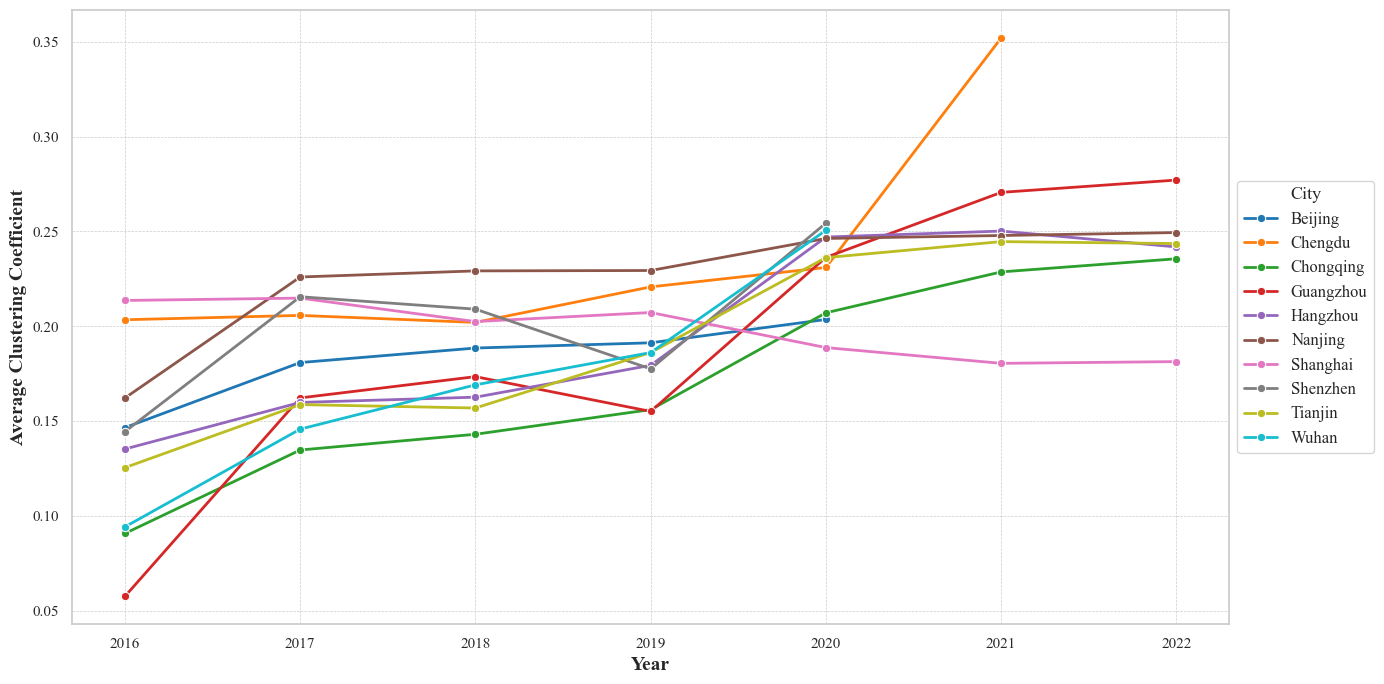

In [11]:
# 设置Seaborn的样式和全局字体为Times New Roman
sns.set(style="whitegrid", font="Times New Roman")

# 获取独特的城市名称
cities = data['city_english'].unique()

# 设置图形大小
plt.figure(figsize=(14, 7))

# 使用Seaborn调色板
palette = sns.color_palette('tab10', len(cities))

# 绘制平均聚类系数的折线图
for i, city in enumerate(cities):
    city_data = data[data['city_english'] == city]
    city_data = city_data.sort_values('year')
    
    sns.lineplot(x=city_data['year'], y=city_data['average_clustering'], label=f'{city}', 
                 marker='o', linewidth=2, color=palette[i])

# 添加标题和标签
# plt.title('Average Clustering Coefficients by City Over Years', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14, weight='bold')
plt.ylabel('Average Clustering Coefficient', fontsize=14, weight='bold')

# 设置图例
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12, title='City', title_fontsize='13', frameon=True)

# 添加网格线
plt.grid(True, linestyle='--', linewidth=0.5)

# 调整布局
plt.tight_layout()
plt.savefig('average_clustering_coefficients.pdf', dpi=300)
plt.show()